# Assignment 4 - Clustering (advanced)

8.12.2024, Krzysztof Czarnowus

Dataset: MNIST dataset containing pictures of 60 000 handwritten digits (description: https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.utils import resample

Importing MNIST dataset

In [5]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Checking of size and content of imported data.

In [6]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


X sets contain 60 000 and 10 000 images as matrices 28 x 28 with RGB pixel code.

Y sets contain labels - digits shown on those images.

### Visualising some of imported data

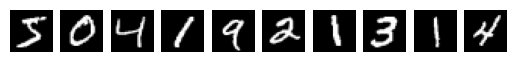

Which represents numbers: 
[5 0 4 1 9 2 1 3 1 4]


In [7]:
for i in range(10):  
    plt.subplot(1, 10, i+1) # 1 wiersz, 10 kolumn
    plt.imshow(X_train[i], cmap = 'gray')
    plt.axis('off')
plt.show()
print("Which represents numbers: ")
print(y_train[:10])

### Preprocessing data

Changing matrices 28x28 to vectors with size of 784 and reducing dimensions using PCA.

PCA (Principal Component Analysis) - procedure that uses orthogonal transformation to reduce size of data, mapping it to lower dimension, while preserving the most important information. Correlated variables are simplified, so in return we have a smaller set of uncorrelated variables.

**Clustering is a method of unsupervised learning, so we will be using only test set, as it contains less data - the calculations won't take too much time**

In [8]:
X = X_test.reshape(X_test.shape[0], -1)
y = y_test

#Scaling data, important when using PCA
scaler = StandardScaler()
X = scaler.fit_transform(X)

#PCA decomposition
pca = PCA(n_components=50, random_state=42) #preserve 100 variables in each record
X = pca.fit_transform(X)

### Validation of clustering results - metrics

One of the most popular metrics is **Silhouette Score**, which indicates how well samples belong to clusters that they're assigned to. Its value is in range [-1, 1], where:
- -1 means that samples are incorrectly assigned
- 0 means that clustering is acceptable, but a lot of samples are on borders of clusters
- 1 means that assignment is perfect

As we have also y set containing real labels of pictures, we may also use **NMI (Normalized Mutual Information)**, which ranges in [0, 1], where 1 is perfect fitting. 0 means about 50% of accuracy!

We will be collecting those metrics for all of used methods.

In [9]:
sil_score = []
nmi = []

def calculate_metric(result):
    score = silhouette_score(X, result)
    sil_score.append(score)
    print("Silhouette score: ", score)

    score = normalized_mutual_info_score(y, result)
    nmi.append(score)
    print("NMI: ", score)    

We will also have a function to visualise assignment of digits to clusters.

In [10]:
def visualize():
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))

    for i in range(10):
        cluster_images = X_test[labels == i]
        for j in range(10):
            axes[i, j].imshow(cluster_images[j], cmap='gray')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

### Clustering images using K-means

When using K-means, it is needed to know the number of clusters. Fortunately, we know that there are only 10 digits to guess.

In [11]:
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(X)

calculate_metric(labels)

Silhouette score:  0.07563433862265669
NMI:  0.44127763806263137


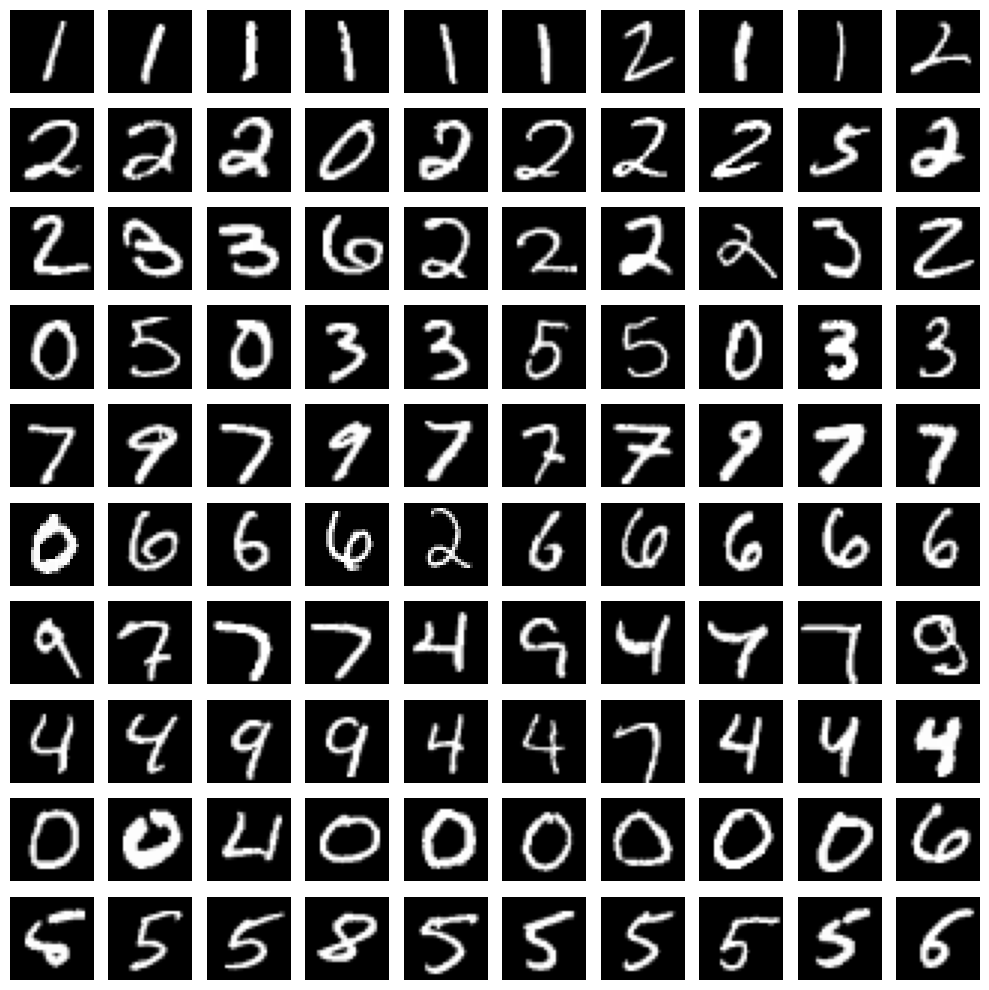

In [12]:
visualize()

We may see that the clustering didn't go very well - although it's not completely random. Some of those clusters show good efficiency.

### Gaussian Mixture Models

GMM differs from K-means as it doesn't assigns clearly data to clusters - it calculates probability that sample is a part of cluster. Clusters can also have different shapes, while in K-means all of them are similar.

In [13]:
gmm = GaussianMixture(n_components=10, random_state=42)
labels = gmm.fit_predict(X)

calculate_metric(labels)

Silhouette score:  0.010969997585499476
NMI:  0.4317142117923405


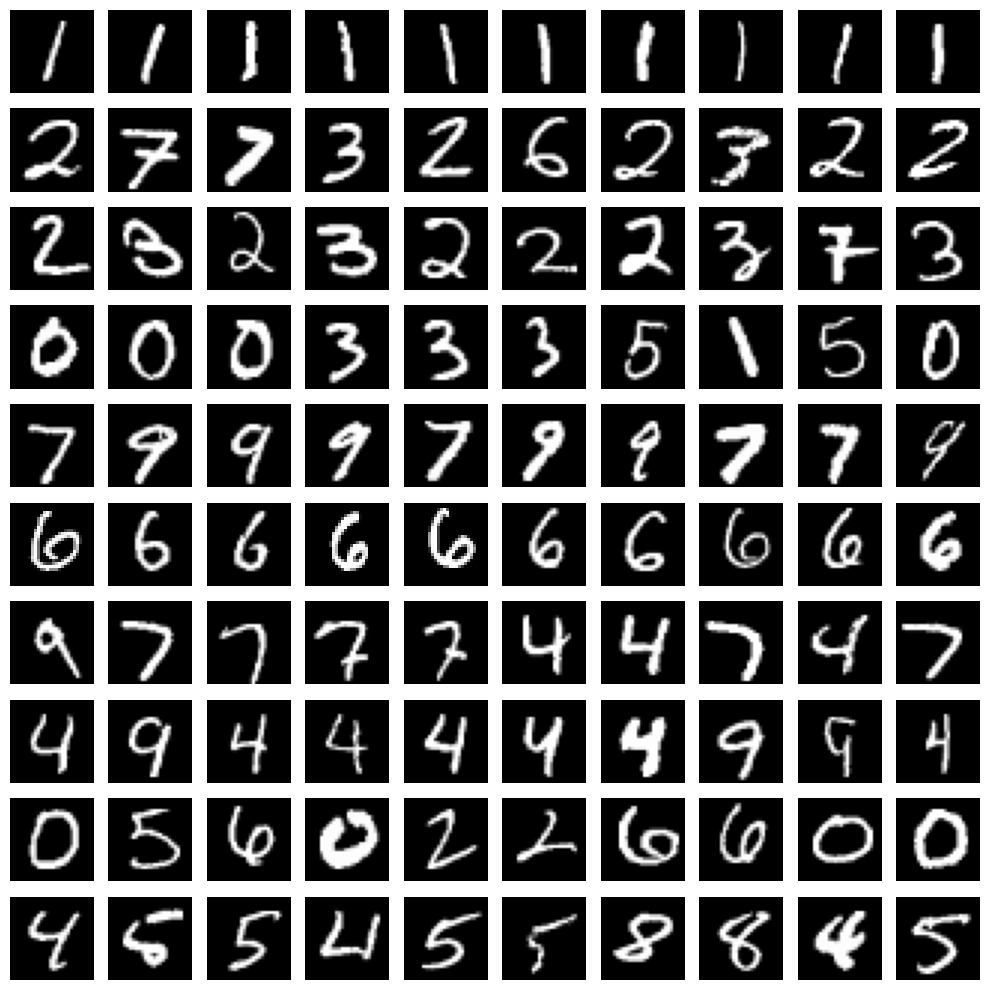

In [14]:
visualize()

GMM model appears to be even less accurate than K-means when it comes to clustering MNIST dataset.

### Hierarchical Clustering - agglomerative

It can find even more irregular cluster shapes, which may be helpful in this case.

Full dataset is too large to be clustered, as it would need enough memory to keep a 60 000 x 60 000 matrix. We will takie only 10% of the original dataset.

In [15]:
hierarchical = AgglomerativeClustering(n_clusters=10)
labels = hierarchical.fit_predict(X)

calculate_metric(labels)

Silhouette score:  0.04132671935390479
NMI:  0.5768447481535652


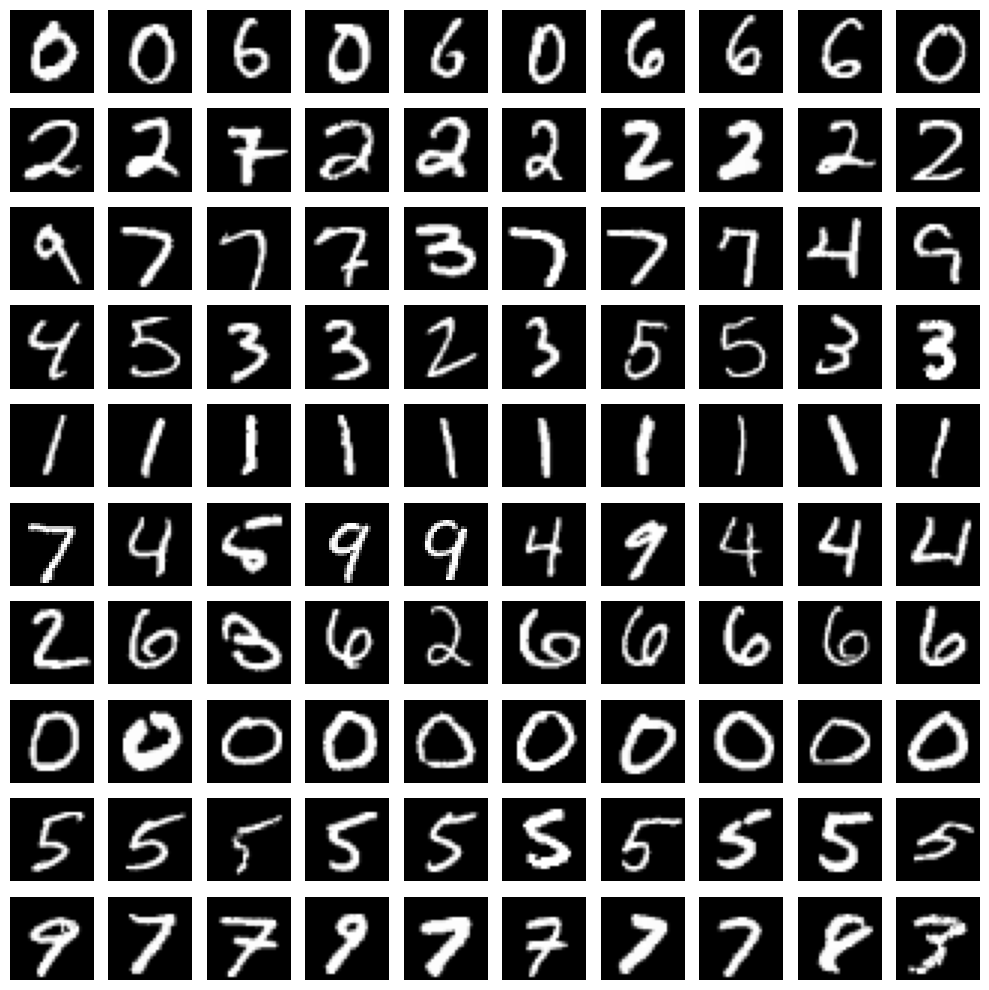

In [16]:
visualize()

The result is much better - hierarchical clustering appears to be more accurate method of clustering performed in the MNIST dataset. It's also the most expensive method - when trying to perform it on train_X, containing 6 times more data, notebook crashed as it needed more than 13 GB of RAM memory to do calculations.

### Summary

In [17]:
df = pd.DataFrame({'silhouette score': sil_score, 'NMI': nmi}, index = ['K-means', 'Gaussian Mixture Models', 'Hierarchical Clustering'])
df

,silhouette score,NMI
K-means,0.075634,0.441278
Gaussian Mixture Models,0.010970,0.431714
Hierarchical Clustering,0.041327,0.576845


### Conclusions

1. Both of used metrices lead to completely different conclusions. According to **silhouette score**, the best results were obtained using K-means; according to **NMI**, hierarchical clustering was the best method.
2. If we didn't have y dataset with labels, we weren't be able use the second of those metrices, which appears to be more accurate, as it compares assigned labels with real ones.
3. Clustering is a method of **unsupervised learning** and it usually don't have labels to check if the results are accurate. All of the available metrics are only hints to consider.
4. **Hierarchical clustering** appears to be the most accurate method when solving problems with this dataset. It is also the most **computionally expensive** algorithm of the used ones. I weren't able to perform calculations on 60 000 records dataset and had to limit it to 10 000, even after **PCA** transformation.
5. **None of used techniques were able to cluster handwritten digits with sufficient accuracy.** If I had a machine with bigger computer power, I would try not to use PCA and perform calculations on a bigger dataset - although I'm not sure if it would help much.